Importing the cocodataset

In [1]:
!pip install CocoDataset==0.1.2

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2021-11-10 19:22:09--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.71.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.71.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  62.7MB/s    in 4.0s    

2021-11-10 19:22:13 (60.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [3]:
from coco_dataset import coco_dataset_download as cocod
class_name='person'  #class name example 
images_count=50       #count of images  
annotations_path='/content/annotations/instances_train2017.json' #path of coco dataset annotations 
#call download function 
cocod.coco_dataset_download(class_name,images_count,annotations_path)

loading annotations into memory...
Done (t=17.37s)
creating index...
index created!
no.of image: 1
no.of image: 2
no.of image: 3
no.of image: 4
no.of image: 5
no.of image: 6
no.of image: 7
no.of image: 8
no.of image: 9
no.of image: 10
no.of image: 11
no.of image: 12
no.of image: 13
no.of image: 14
no.of image: 15
no.of image: 16
no.of image: 17
no.of image: 18
no.of image: 19
no.of image: 20
no.of image: 21
no.of image: 22
no.of image: 23
no.of image: 24
no.of image: 25
no.of image: 26
no.of image: 27
no.of image: 28
no.of image: 29
no.of image: 30
no.of image: 31
no.of image: 32
no.of image: 33
no.of image: 34
no.of image: 35
no.of image: 36
no.of image: 37
no.of image: 38
no.of image: 39
no.of image: 40
no.of image: 41
no.of image: 42
no.of image: 43
no.of image: 44
no.of image: 45
no.of image: 46
no.of image: 47
no.of image: 48
no.of image: 49
no.of image: 50
finished images download


Importing required libraries

In [4]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout 
from torch.optim import Adam, SGD

loading training images

In [5]:
# loading training images
import cv2
import os
folder = '/content/person/'
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

# converting the list to numpy array
train_x = np.array(load_images_from_folder(folder))
# defining the target
train_x.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(51,)

visualizing images

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a88ed3fd0>,
 <matplotlib.image.AxesImage at 0x7f6a88dde490>)

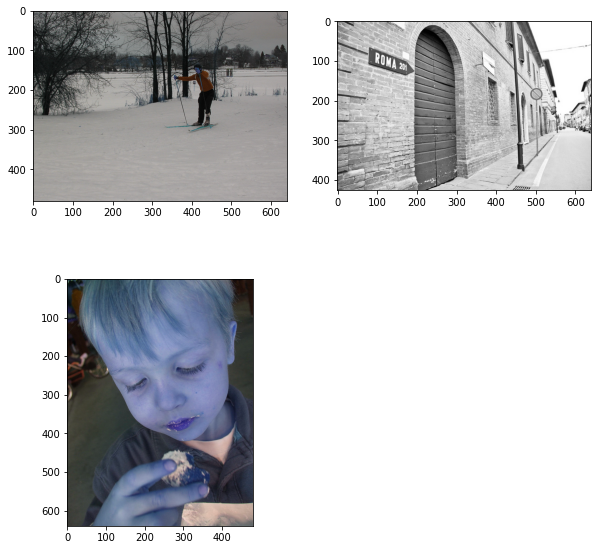

In [7]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')


MASK RCNN Architecture with Resnet-50 backbone

Region Proposal Network

In [36]:
class ResnetRegionProposalNetwork(torch.nn.Module):
    def __init__(self):
        super(ResnetRegionProposalNetwork, self).__init__()
        self.resnet_backbone = torch.nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-3])
        non_trainable_backbone_layers = 5
        counter = 0
        for child in self.resnet_backbone:
            if counter < non_trainable_backbone_layers:
                for param in child.parameters():
                    param.requires_grad = False
                counter += 1
            else:
                break

        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        self.rpn_anchor_generator = rpn.AnchorGenerator(
            anchor_sizes, aspect_ratios
        )
        out_channels = 1024
        self.rpn_head = rpn.RPNHead(
            out_channels, self.rpn_anchor_generator.num_anchors_per_location()[0]
        )

        rpn_pre_nms_top_n = {"training": 2000, "testing": 1000}
        rpn_post_nms_top_n = {"training": 2000, "testing": 1000}
        rpn_nms_thresh = 0.7
        rpn_fg_iou_thresh = 0.7
        rpn_bg_iou_thresh = 0.2
        rpn_batch_size_per_image = 256
        rpn_positive_fraction = 0.5

        self.rpn = rpn.RegionProposalNetwork(
            self.rpn_anchor_generator, self.rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

    def forward(self,
                images,       # type: ImageList
                targets=None  # type: Optional[List[Dict[str, Tensor]]]
                ):
        feature_maps = self.resnet_backbone(images)
        features = {"0": feature_maps}
        image_sizes = getImageSizes(images)
        image_list = il.ImageList(images, image_sizes)
        return self.rpn(image_list, features, targets)

Region Of Interest (ROI)

In [10]:
import numpy as np
import torch
import torch.nn as nn

floattype = torch.cuda.FloatTensor

class TorchROIPool(object):

    def __init__(self, output_size, scaling_factor):
      
        self.output_size = output_size
        self.scaling_factor = scaling_factor

    def _roi_pool(self, features):
       m_channels, proposal_width, proposal_height
      

        num_channels, h, w = features.shape

        w_stride = w/self.output_size
        h_stride = h/self.output_size

        res = torch.zeros((num_channels, self.output_size, self.output_size))
        res_idx = torch.zeros((num_channels, self.output_size, self.output_size))
        for i in range(self.output_size):
            for j in range(self.output_size):
                
                # important to round the start and end, and then conver to int
                w_start = int(np.floor(j*w_stride))
                w_end = int(np.ceil((j+1)*w_stride))
                h_start = int(np.floor(i*h_stride))
                h_end = int(np.ceil((i+1)*h_stride))

                # limiting start and end based on feature limits
                w_start = min(max(w_start, 0), w)
                w_end = min(max(w_end, 0), w)
                h_start = min(max(h_start, 0), h)
                h_end = min(max(h_end, 0), h)

                patch = features[:, h_start: h_end, w_start: w_end]
                max_val, max_idx = torch.max(patch.reshape(num_channels, -1), dim=1)
                res[:, i, j] = max_val
                res_idx[:, i, j] = max_idx

        return res, res_idx

    def __call__(self, feature_layer, proposals):
        

        batch_size, num_channels, _, _ = feature_layer.shape

        # first scale proposals based on self.scaling factor 
        scaled_proposals = torch.zeros_like(proposals)

        # the rounding by torch.ceil is important for ROI pool
        scaled_proposals[:, 0] = torch.ceil(proposals[:, 0] * self.scaling_factor)
        scaled_proposals[:, 1] = torch.ceil(proposals[:, 1] * self.scaling_factor)
        scaled_proposals[:, 2] = torch.ceil(proposals[:, 2] * self.scaling_factor)
        scaled_proposals[:, 3] = torch.ceil(proposals[:, 3] * self.scaling_factor)

        res = torch.zeros((len(proposals), num_channels, self.output_size,
                        self.output_size))
        res_idx = torch.zeros((len(proposals), num_channels, self.output_size,
                        self.output_size))
        for idx in range(len(proposals)):
            proposal = scaled_proposals[idx]
            # adding 1 to include the end indices from proposal
            extracted_feat = feature_layer[0, :, proposal[1].to(dtype=torch.int8):proposal[3].to(dtype=torch.int8)+1, proposal[0].to(dtype=torch.int8):proposal[2].to(dtype=torch.int8)+1]
            res[idx], res_idx[idx] = self._roi_pool(extracted_feat)

        return res

In [12]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO

In [13]:
import torch
import torchvision

In [14]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [24]:
model = model.cuda()

In [25]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

Performing Masking

In [26]:
def get_prediction(img_path, threshold=0.5, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [28]:
import cv2 # opencv

In [29]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
  resp = urlopen(url) # We want to convert URL to cv2 image here, so we can draw the mask and bounding boxes
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, readFlag)
  return image

In [30]:
import random

Applying colors to mask

In [31]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

Method for Instance segmentation

In [32]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

Testing with an image

In [33]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg

--2021-11-10 19:35:24--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178423 (2.1M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   2.08M  --.-KB/s    in 0.06s   

2021-11-10 19:35:24 (34.9 MB/s) - ‘car.jpg’ saved [2178423/2178423]



In [34]:
img, pred_classes, masks = instance_segmentation('./car.jpg', rect_th=5, text_th=4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


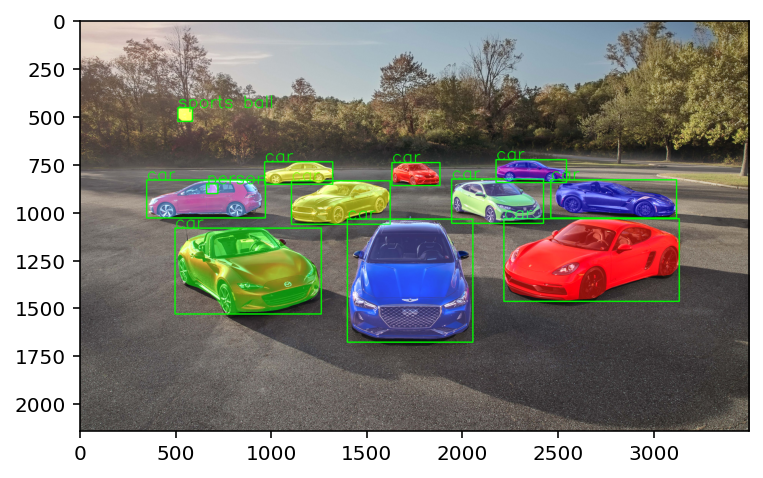

In [35]:
plt.imshow(img)